# Vielversprechender Ansatz inkl 
* inklusive preprocessing
* inklusive data augmentation!
* taken from [huboquiang](http://huboqiang.cn/2017/02/04/CatVsDog)

In [ ]:
from __future__ import print_function
from __future__ import absolute_import

import os
import shutil
import random
import warnings

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.random.seed(0)
# für hübsche progress bars
# from   tqdm import * 
from   sklearn.model_selection import train_test_split

import tensorflow as tf
from   keras           import backend as K
from   keras.models    import Model
from   keras.layers    import Dense, Input, BatchNormalization, Activation, merge, Dropout
from   keras.layers    import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D
from   keras.callbacks import ModelCheckpoint
from   keras.preprocessing       import image
from   keras.preprocessing.image import ImageDataGenerator
from   keras.engine.topology     import get_source_inputs
from   keras.utils.data_utils    import get_file
from   keras.applications.imagenet_utils import decode_predictions, _obtain_input_shape

%matplotlib inline

# 1. Preprocessing for the input images

In [32]:
root_prefix = "datasets"

train_filenames = os.listdir('%s/train_large/' % (root_prefix))
test_filenames  = os.listdir('%s/test_large/'  % (root_prefix))
print(train_filenames[0:10])
print(test_filenames[0:10])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg', 'cat.10002.jpg', 'cat.10003.jpg', 'cat.10004.jpg']
['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg', '10005.jpg']


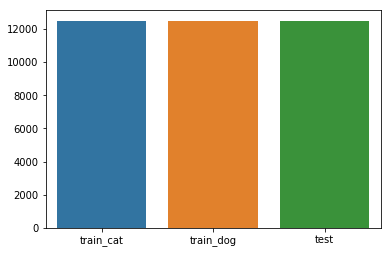

In [18]:
train_cat = filter(lambda x: x.split(".")[0] == "cat", train_filenames)
train_dog = filter(lambda x: x.split(".")[0] == "dog", train_filenames)
x = ['train_cat', 'train_dog', 'test']
y = [len(list(train_cat)), len(list(train_dog)), len(test_filenames)]
ax = sns.barplot(x=x, y=y)

In [19]:
my_train, my_cv = train_test_split(train_filenames, test_size=0.1, random_state=0)
print(len(my_train), len(my_cv))

22500 2500


In [9]:
def remove_and_create_class(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)
    os.mkdir(dirname+'/cat')
    os.mkdir(dirname+'/dog')

In [10]:
remove_and_create_class('%s/mytrain' % (root_prefix))
remove_and_create_class('%s/myvalid' % (root_prefix))

for filename in filter(lambda x: x.split(".")[0] == "cat", my_train):
    os.symlink('%s/train/' % (root_prefix)+filename, '%s/mytrain/cat/' % (root_prefix)+filename)

for filename in filter(lambda x: x.split(".")[0] == "dog", my_train):
    os.symlink('%s/train/' % (root_prefix)+filename, '%s/mytrain/dog/' % (root_prefix)+filename)

for filename in filter(lambda x: x.split(".")[0] == "cat", my_cv):
    os.symlink('%s/train/' % (root_prefix)+filename, '%s/myvalid/cat/' % (root_prefix)+filename)

for filename in filter(lambda x: x.split(".")[0] == "dog", my_cv):
    os.symlink('%s/train/' % (root_prefix)+filename, '%s/myvalid/dog/' % (root_prefix)+filename)

# 2. Setting the generator of input files for training process

In [39]:
image_width  = 299
image_height = 299
image_size = (image_width, image_height)

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
        '%s/mytrain' % (root_prefix),
        target_size=image_size,  # all images will be resized to 299x299
        batch_size=16,
        class_mode='binary',
        follow_links=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
        '%s/myvalid' % (root_prefix),
        target_size=image_size, 
        batch_size=16,
        class_mode='binary',
        follow_links=True)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [38]:
x, y = train_generator.next()

plt.figure(figsize=(16, 8))
for i, (img, label) in enumerate(zip(x, y)):
    plt.subplot(3, 6, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

OSError: [Errno 22] Invalid argument: 'datasets/mytrain\\cat\\cat.743.jpg'